GitHub Repo:https://github.com/Bijal-hub/ML_Assignment_CIFAR10.git

In [2]:
# ============================================================
# 1. Imports and basic setup
# ============================================================
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
import time

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:

# ============================================================
# 2. Load and preprocess CIFAR-10
# ============================================================
# CIFAR-10: 50k train, 10k test, 10 classes, 32x32 RGB images
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

num_classes = 10
y_train = y_train.flatten()
y_test = y_test.flatten()

print("Train shape:", x_train.shape, "Labels:", y_train.shape)
print("Test shape:", x_test.shape, "Labels:", y_test.shape)

# Normalise to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Create validation split from training set
VAL_FRACTION = 0.1
num_val = int(len(x_train) * VAL_FRACTION)

x_val = x_train[:num_val]
y_val = y_train[:num_val]

x_train_small = x_train[num_val:]
y_train_small = y_train[num_val:]

print("New train shape:", x_train_small.shape)
print("Val shape:", x_val.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Train shape: (50000, 32, 32, 3) Labels: (50000,)
Test shape: (10000, 32, 32, 3) Labels: (10000,)
New train shape: (45000, 32, 32, 3)
Val shape: (5000, 32, 32, 3)


In [4]:
# ============================================================
# 3. Data augmentation pipeline (using Keras preprocessing layers)
# ============================================================

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)



In [5]:

# ============================================================
# 4. CNN model builder with regularisation
# ============================================================
def make_cnn_model(weight_decay=1e-4, dropout_rate=0.5, input_shape=(32, 32, 3), num_classes=10):
    """
    Simple but decent CNN for CIFAR-10.
    We keep the architecture fixed and only change optimiser / LR / regularisation
    when running experiments.
    """
    wd = regularizers.l2(weight_decay) if weight_decay is not None else None

    inputs = keras.Input(shape=input_shape)

    # Include augmentation as part of the model (only active in training)
    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate / 2)(x)  # a bit lower than final FC dropout

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate / 2)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate / 2)(x)

    # Classifier head
    x = layers.Flatten()(x)
    x = layers.Dense(256, kernel_regularizer=wd)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_cifar10_reg")
    return model



In [6]:
def create_optimizer_and_schedule(config, steps_per_epoch):
    """
    Given a config dict, return an optimiser (possibly with schedule).
    This makes it easy to run multiple experiments.
    """
    base_lr = config["base_lr"]
    opt_name = config["optimizer"]

    schedule_type = config.get("schedule", "constant")  # 'constant', 'exp_decay', 'cosine'
    schedule = None

    if schedule_type == "constant":
        lr = base_lr

    elif schedule_type == "exp_decay":
        decay_rate = config.get("decay_rate", 0.96)

        # FIX: handle None values properly
        decay_steps = config.get("decay_steps")
        if decay_steps is None:
            decay_steps = steps_per_epoch * 5

        schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=base_lr,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=True,
        )

        lr = schedule

    elif schedule_type == "cosine":
        # CosineDecayRestarts is nice to show in your tutorial
        first_decay_steps = config.get("first_decay_steps", steps_per_epoch * 5)
        schedule = keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate=base_lr,
            first_decay_steps=first_decay_steps,
        )
        lr = schedule

    else:
        raise ValueError(f"Unknown schedule type: {schedule_type}")

    if opt_name.lower() == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt_name.lower() == "sgd":
        momentum = config.get("momentum", 0.9)
        nesterov = config.get("nesterov", False)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    return optimizer, schedule

In [7]:
# ============================================================
# 6. Training utility (runs one experiment)
# ============================================================
def train_one_experiment(config, x_train, y_train, x_val, y_val, run_dir="runs"):
    """
    Train one model according to 'config' and return history + test metrics.
    Config example:
    {
      "name": "adam_constant_lr",
      "optimizer": "adam",
      "base_lr": 1e-3,
      "schedule": "constant",
      "weight_decay": 1e-4,
      "dropout": 0.5,
      "batch_size": 64,
      "epochs": 20,
      "use_reduce_on_plateau": False
    }
    """
    os.makedirs(run_dir, exist_ok=True)

    batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 20)

    # Build model
    model = make_cnn_model(
        weight_decay=config.get("weight_decay", 1e-4),
        dropout_rate=config.get("dropout", 0.5),
        input_shape=x_train.shape[1:],
        num_classes=num_classes,
    )

    steps_per_epoch = int(np.ceil(len(x_train) / batch_size))

    optimizer, schedule = create_optimizer_and_schedule(config, steps_per_epoch)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.summary()

    callbacks = []

    # Optional ReduceLROnPlateau (good for SGD)
    if config.get("use_reduce_on_plateau", False):
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1,
        )
        callbacks.append(reduce_cb)

    # Early stopping to avoid overfitting / wasted time
    early_cb = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True,
        verbose=1,
    )
    callbacks.append(early_cb)

    # Save best model weights
    checkpoint_path = os.path.join(run_dir, f"{config['name']}_best.keras")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1,
    )
    callbacks.append(checkpoint_cb)

    print(f"\n===== Starting experiment: {config['name']} =====")
    start_time = time.time()
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=2,
    )
    train_time = time.time() - start_time
    print(f"Training time: {train_time/60:.2f} minutes")

    return model, history, train_time


In [8]:
# ============================================================
# 7. Plotting helpers
# ============================================================
def plot_history(history, title="Training history"):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure()
    plt.plot(epochs, hist["loss"], label="Train loss")
    plt.plot(epochs, hist["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs, hist["accuracy"], label="Train acc")
    plt.plot(epochs, hist["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


# CIFAR-10 class names (for nice confusion matrix)
cifar10_class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


In [10]:

# ============================================================
# 8. Define experiments (optimiser + LR schedule + regularisation)
# ============================================================
experiments = [
    # 1. Adam + constant LR + light regularisation
    {
        "name": "exp1_adam_constant_lr",
        "optimizer": "adam",
        "base_lr": 1e-3,
        "schedule": "constant",
        "weight_decay": 1e-4,
        "dropout": 0.4,
        "batch_size": 64,
        "epochs": 20,
        "use_reduce_on_plateau": False,
    },
    # 2. Adam + ExponentialDecay + stronger regularisation
    {
        "name": "exp2_adam_exp_decay",
        "optimizer": "adam",
        "base_lr": 1e-3,
        "schedule": "exp_decay",
        "decay_rate": 0.9,
        "decay_steps": None,  # will use default = steps_per_epoch*5
        "weight_decay": 5e-4,  # stronger L2
        "dropout": 0.5,
        "batch_size": 64,
        "epochs": 25,
        "use_reduce_on_plateau": False,
    },





    # 3. SGD + Momentum + constant LR
    {
        "name": "exp3_sgd_momentum_constant_lr",
        "optimizer": "sgd",
        "base_lr": 0.05,
        "schedule": "constant",
        "momentum": 0.9,
        "nesterov": True,
        "weight_decay": 1e-4,
        "dropout": 0.4,
        "batch_size": 128,
        "epochs": 30,
        "use_reduce_on_plateau": False,
    },
    # 4. SGD + Momentum + ReduceLROnPlateau (no explicit LR schedule)
    {
        "name": "exp4_sgd_momentum_plateau",
        "optimizer": "sgd",
        "base_lr": 0.05,
        "schedule": "constant",  # LR decays via ReduceLROnPlateau callback
        "momentum": 0.9,
        "nesterov": True,
        "weight_decay": 5e-4,
        "dropout": 0.5,
        "batch_size": 128,
        "epochs": 40,
        "use_reduce_on_plateau": True,
    },
]

# Dictionary to store results
results = []


Model: "cnn_cifar10_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Starting experiment: exp1_adam_constant_lr =====
Epoch 1/20

Epoch 1: val_loss improved from inf to 1.57594, saving model to runs/exp1_adam_constant_lr_best.keras
704/704 - 20s - 29ms/step - accuracy: 0.4458 - loss: 1.6444 - val_accuracy: 0.4954 - val_loss: 1.5759
Epoch 2/20

Epoch 2: val_loss improved from 1.57594 to 1.15863, saving model to runs/exp1_adam_constant_lr_best.keras
704/704 - 10s - 14ms/step - accuracy: 0.6002 - loss: 1.2300 - val_accuracy: 0.6340 - val_loss: 1.1586
Epoch 3/20

Epoch 3: val_loss improved from 1.15863 to 1.01981, saving model to runs/exp1_adam_constant_lr_best.keras
704/704 - 10s - 14ms/step - accuracy: 0.6590 - loss: 1.0868 - val_accuracy: 0.6902 - val_loss: 1.0198
Epoch 4/20

Epoch 4: val_loss did not improve from 1.01981
704/704 - 9s - 13ms/step - accuracy: 0.6943 - loss: 1.0043 - val_accuracy: 0.6664 - val_loss: 1.1155
Epoch 5/20

Epoch 5: val_loss did not improve from 1.01981
704/704 - 9s - 13ms/step - accuracy: 0.7151 - loss: 0.9569 - val_accu

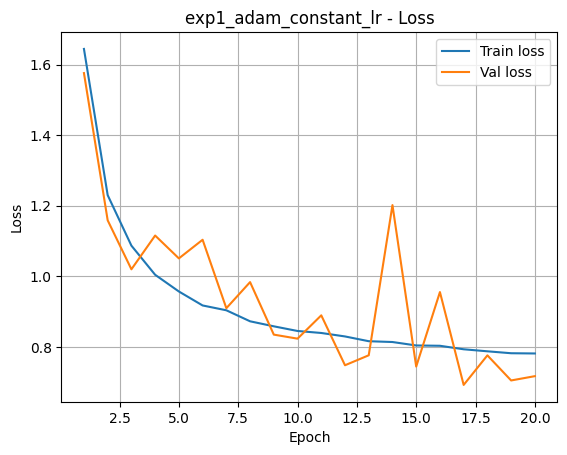

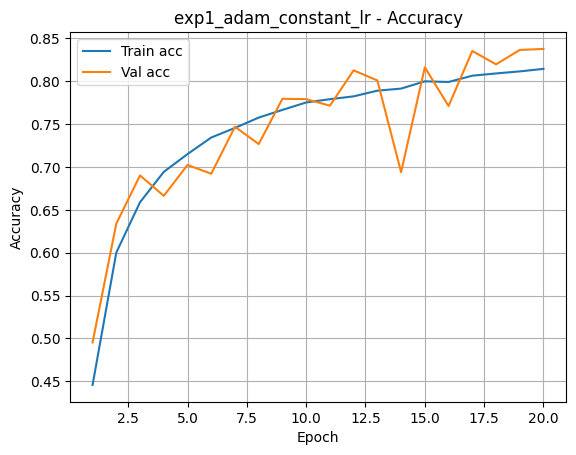

Model: "cnn_cifar10_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Starting experiment: exp2_adam_exp_decay =====
Epoch 1/25

Epoch 1: val_loss improved from inf to 1.68642, saving model to runs/exp2_adam_exp_decay_best.keras
704/704 - 15s - 22ms/step - accuracy: 0.4205 - loss: 2.0392 - val_accuracy: 0.5364 - val_loss: 1.6864
Epoch 2/25

Epoch 2: val_loss improved from 1.68642 to 1.50430, saving model to runs/exp2_adam_exp_decay_best.keras
704/704 - 9s - 13ms/step - accuracy: 0.5746 - loss: 1.5552 - val_accuracy: 0.6004 - val_loss: 1.5043
Epoch 3/25

Epoch 3: val_loss improved from 1.50430 to 1.26651, saving model to runs/exp2_adam_exp_decay_best.keras
704/704 - 10s - 14ms/step - accuracy: 0.6362 - loss: 1.3629 - val_accuracy: 0.6664 - val_loss: 1.2665
Epoch 4/25

Epoch 4: val_loss improved from 1.26651 to 1.21007, saving model to runs/exp2_adam_exp_decay_best.keras
704/704 - 9s - 13ms/step - accuracy: 0.6662 - loss: 1.2609 - val_accuracy: 0.6820 - val_loss: 1.2101
Epoch 5/25

Epoch 5: val_loss did not improve from 1.21007
704/704 - 9s - 13ms/s

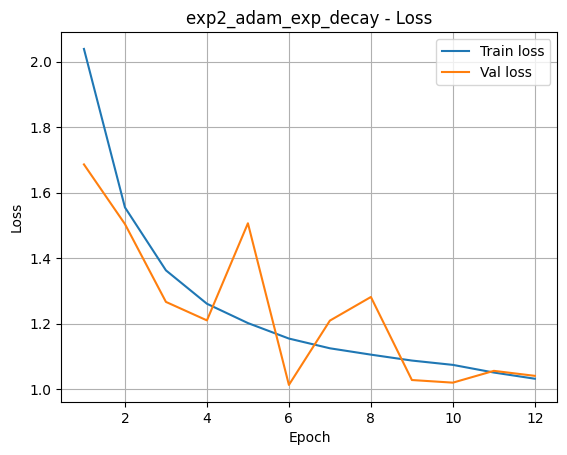

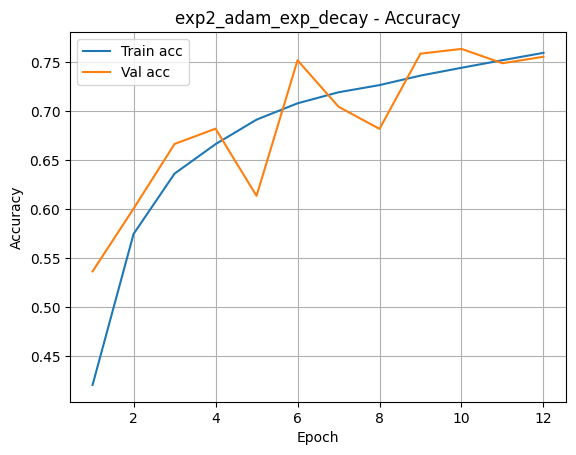

Model: "cnn_cifar10_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Starting experiment: exp3_sgd_momentum_constant_lr =====
Epoch 1/30

Epoch 1: val_loss improved from inf to 1.51734, saving model to runs/exp3_sgd_momentum_constant_lr_best.keras
352/352 - 9s - 27ms/step - accuracy: 0.4334 - loss: 1.6744 - val_accuracy: 0.4840 - val_loss: 1.5173
Epoch 2/30

Epoch 2: val_loss did not improve from 1.51734
352/352 - 4s - 11ms/step - accuracy: 0.5708 - loss: 1.2972 - val_accuracy: 0.5100 - val_loss: 1.5229
Epoch 3/30

Epoch 3: val_loss improved from 1.51734 to 1.10629, saving model to runs/exp3_sgd_momentum_constant_lr_best.keras
352/352 - 4s - 11ms/step - accuracy: 0.6384 - loss: 1.1333 - val_accuracy: 0.6538 - val_loss: 1.1063
Epoch 4/30

Epoch 4: val_loss improved from 1.10629 to 0.98823, saving model to runs/exp3_sgd_momentum_constant_lr_best.keras
352/352 - 4s - 11ms/step - accuracy: 0.6776 - loss: 1.0298 - val_accuracy: 0.6996 - val_loss: 0.9882
Epoch 5/30

Epoch 5: val_loss improved from 0.98823 to 0.97337, saving model to runs/exp3_sgd_momen

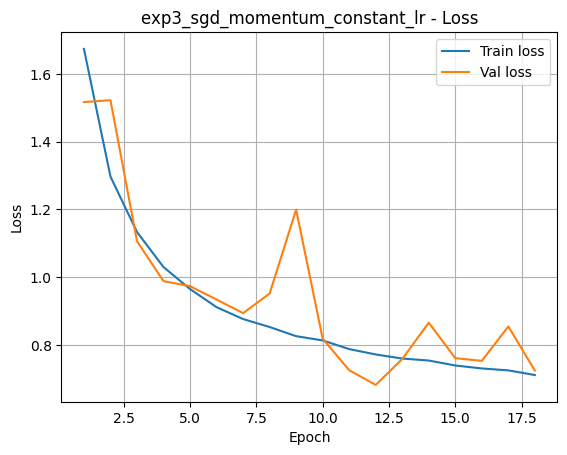

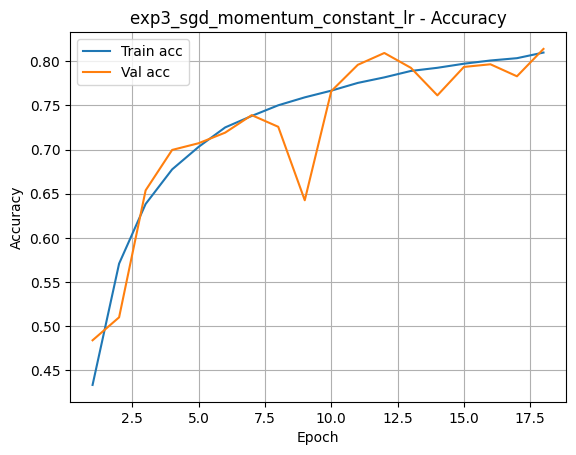

Model: "cnn_cifar10_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Starting experiment: exp4_sgd_momentum_plateau =====
Epoch 1/40

Epoch 1: val_loss improved from inf to 1.70875, saving model to runs/exp4_sgd_momentum_plateau_best.keras
352/352 - 8s - 23ms/step - accuracy: 0.3921 - loss: 2.1301 - val_accuracy: 0.5208 - val_loss: 1.7088 - learning_rate: 0.0500
Epoch 2/40

Epoch 2: val_loss improved from 1.70875 to 1.54322, saving model to runs/exp4_sgd_momentum_plateau_best.keras
352/352 - 4s - 11ms/step - accuracy: 0.5425 - loss: 1.6496 - val_accuracy: 0.5668 - val_loss: 1.5432 - learning_rate: 0.0500
Epoch 3/40

Epoch 3: val_loss improved from 1.54322 to 1.34849, saving model to runs/exp4_sgd_momentum_plateau_best.keras
352/352 - 4s - 12ms/step - accuracy: 0.6132 - loss: 1.4224 - val_accuracy: 0.6486 - val_loss: 1.3485 - learning_rate: 0.0500
Epoch 4/40

Epoch 4: val_loss improved from 1.34849 to 1.22739, saving model to runs/exp4_sgd_momentum_plateau_best.keras
352/352 - 4s - 11ms/step - accuracy: 0.6533 - loss: 1.2898 - val_accuracy: 0.6716

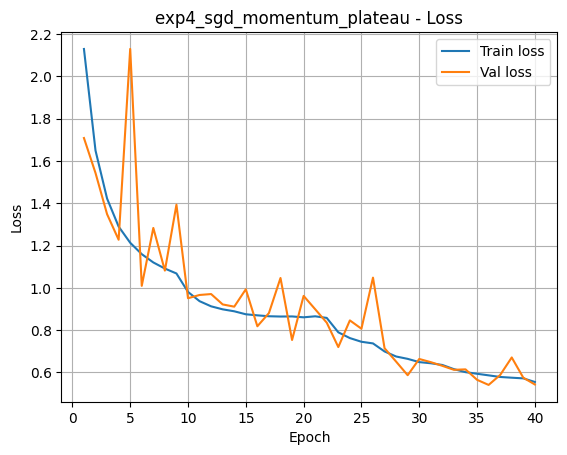

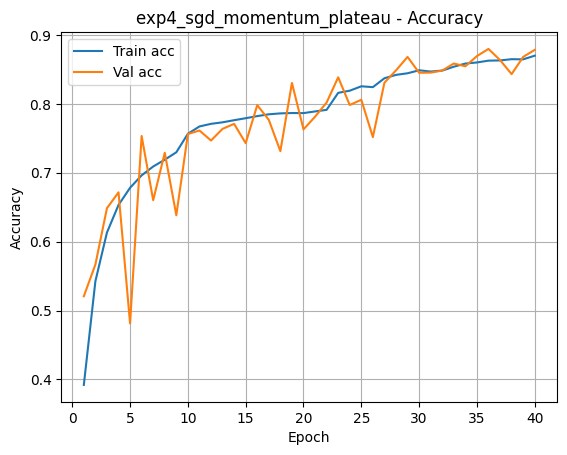

                            name optimizer                      schedule  \
0          exp1_adam_constant_lr      adam                      constant   
1            exp2_adam_exp_decay      adam                     exp_decay   
2  exp3_sgd_momentum_constant_lr       sgd                      constant   
3      exp4_sgd_momentum_plateau       sgd  constant + ReduceLROnPlateau   

   base_lr  weight_decay  dropout  batch_size  epochs_ran  val_acc  test_acc  \
0    0.001        0.0001      0.4          64          20   0.8354    0.8354   
1    0.001        0.0005      0.5          64          12   0.7520    0.7451   
2    0.050        0.0001      0.4         128          18   0.8094    0.7963   
3    0.050        0.0005      0.5         128          40   0.8798    0.8647   

   train_time_min  
0        3.335337  
1        1.983579  
2        1.269015  
3        2.706236  


In [11]:
# ============================================================
# 9. Run experiments (you can comment/uncomment to save time)
# ============================================================
trained_models = {}

for cfg in experiments:
    model, history, train_time = train_one_experiment(
        cfg,
        x_train_small,
        y_train_small,
        x_val,
        y_val,
        run_dir="runs",
    )

    # Evaluate on val and test
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    plot_history(history, title=cfg["name"])

    results.append(
        {
            "name": cfg["name"],
            "optimizer": cfg["optimizer"],
            "schedule": cfg["schedule"] + (" + ReduceLROnPlateau" if cfg.get("use_reduce_on_plateau", False) else ""),
            "base_lr": cfg["base_lr"],
            "weight_decay": cfg["weight_decay"],
            "dropout": cfg["dropout"],
            "batch_size": cfg["batch_size"],
            "epochs_ran": len(history.history["loss"]),
            "val_acc": val_acc,
            "test_acc": test_acc,
            "train_time_min": train_time / 60.0,
        }
    )

    trained_models[cfg["name"]] = model

# Show summary table
results_df = pd.DataFrame(results)
print(results_df)


Best experiment based on val_acc: exp4_sgd_momentum_plateau
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification report:

              precision    recall  f1-score   support

    airplane       0.90      0.85      0.88      1000
  automobile       0.94      0.95      0.95      1000
        bird       0.88      0.77      0.82      1000
         cat       0.78      0.72      0.75      1000
        deer       0.83      0.84      0.83      1000
         dog       0.84      0.78      0.81      1000
        frog       0.77      0.96      0.85      1000
       horse       0.91      0.90      0.91      1000
        ship       0.92      0.94      0.93      1000
       truck       0.89      0.94      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



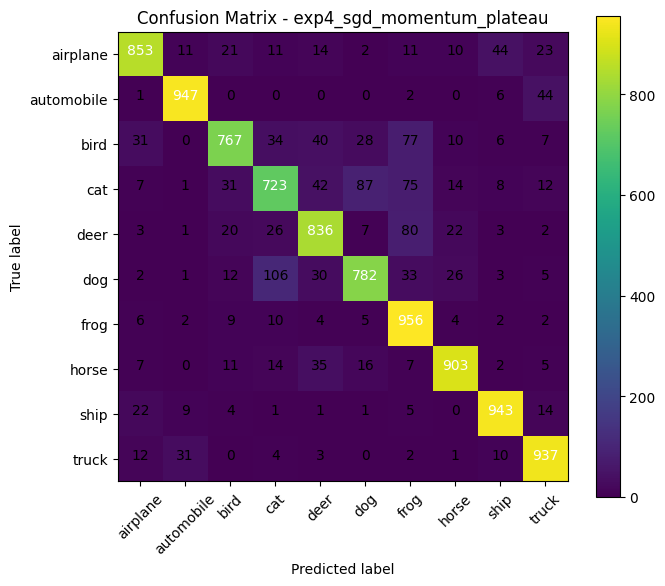

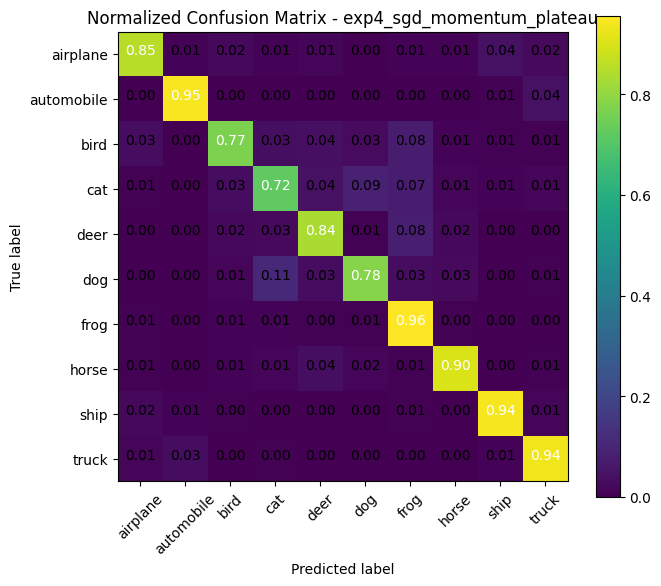

In [12]:
# ============================================================
# 10. Confusion matrix for the best model
# ============================================================
# Pick best experiment by validation accuracy
best_exp = max(results, key=lambda r: r["val_acc"])
best_name = best_exp["name"]
print("\nBest experiment based on val_acc:", best_name)

best_model = trained_models[best_name]

# Predictions on test set
y_pred_probs = best_model.predict(x_test, batch_size=128)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=cifar10_class_names))

plot_confusion_matrix(cm, cifar10_class_names, normalize=False, title=f"Confusion Matrix - {best_name}")
plot_confusion_matrix(cm, cifar10_class_names, normalize=True, title=f"Normalized Confusion Matrix - {best_name}")
